In [3]:
import wandb
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [4]:
api = wandb.Api()
entity = "evangeorgerex"
project = "fwal"

results_dir = r'/home/er647/projects/feature-wise-active-learning/results'

# Utilities

# Load baselines

## From csv

In [5]:
# load baselines_df from csv
baselines_df = pd.read_csv(results_dir + '/baselines_df.csv')

baselines_df = baselines_df[(baselines_df['imputation'] == 'mean') & (baselines_df['method'] == 'mnar')]
baselines_df['model'] = baselines_df['base_model']
baselines_df['% Features Selected'] = 100 - baselines_df['missing_perc']

baselines_df = baselines_df[['dataset', 'model', 'F1', '% Features Selected']]

In [ ]:
# need the sweeps ids for cae and supervised cae. Plan is to create a df with the same columns as above then concat. Will need to load the data frm the runs. 

In [6]:
cae_sweep_ids = [
    'h245pc2i', 
    'jqulrkke', # finance
    'xh18ha0v', # PBMC
]

scae_sweep_ids = [
    '8yghctpp', 
    'xclyvl0c', # finance
    'vle39arl', # PBMC
]

def get_caes_df(sweep_ids):
    caes_df = [] # pd.DataFrame(columns=['dataset', 'model', 'F1', '% Features Selected'])
    for sweep_id in sweep_ids:
        runs =  api.sweep(f"{entity}/{project}/{sweep_id}").runs
        for run in runs:
            if run.state != "finished":
                continue
            # num_features = run.config['num_features']
            
            percentage = run.config['CAE_neurons_ratio']
            
            # num_features = num_features * percentage
            
            caes_df.append({
                # 'sweep_id': sweep_id,
                'dataset': run.config['dataset'],
                'model': run.config['model'],
                'F1': run.summary['bestmodel_test/F1_weighted'],
                '% Features Selected': 100 * percentage
            })
    return pd.DataFrame(caes_df)

In [7]:
cae_df = get_caes_df(cae_sweep_ids)

In [8]:
scae_df = get_caes_df(scae_sweep_ids)

# Fact

## Fact utilities

## Load from csv

In [9]:
# load from csv
fact_df = pd.read_csv(results_dir + '/fact_df.csv')

In [10]:
fact_df = fact_df[(fact_df['method'] == 'mnar')]
fact_df['model'] = fact_df['base_model']
fact_df['% Features Selected'] = 100 - fact_df['missing_perc']

fact_df = fact_df[['dataset', 'model', 'F1', '% Features Selected']]

# Plotting

## Plot utilities

In [11]:
df = pd.concat([baselines_df, cae_df, scae_df, fact_df])
df = df[df['dataset'] != 'poly_binarised_decimalised_synth']
# df = df[~((df['dataset'] == 'USPS') & (df['missing_perc'] > df[(df['dataset'] == 'USPS') & (df['model'] =='F-Act')]['missing_perc'].max()))]

In [12]:
def plot_f1_vs_feature_selection(df, dataset_name, ax, base_model_color):
    """
    Plots F1 score against the fraction of missing features from a DataFrame,
    without creating a legend in each subplot. Specific line styles based on the model type are used.
    
    Parameters:
    - df (pd.DataFrame): DataFrame containing the data.
    - dataset_name (str): Name of the dataset to filter on.
    - method (str): Method to filter on.
    - ax (matplotlib.axes._subplots.AxesSubplot): Axes object to draw the plot on.
    - base_model_color (dict): Dictionary mapping base models to colors.
    - line_styles (dict): Dictionary mapping models to line styles.
    """
    # Filter the DataFrame based on the dataset name and method
    filtered_df = df[(df['dataset'] == dataset_name)]
    
    # Plot on the given axes object
    unique_models = filtered_df['model'].unique()
    for model in unique_models:
        subset = filtered_df[filtered_df['model'] == model]
        # Use base_model field to determine color
        base_model = subset['model'].iloc[0]  # Assuming each model has a consistent base_model
        label_name = 'F-Act (Ours)' if model == 'F-Act' else model
        sns.lineplot(data=subset, x='% Features Selected', y='F1', label=label_name,
                    color=base_model_color[base_model], marker='o', ax=ax)
    
    # Set subplot title and labels
        # Set subplot title and labels
    title_map = {
        'USPS': 'USPS', 
        'mice_protein': 'Mice Protein', 
        'Isolet': 'Isolet', 
        'madelon': 'Madelon', 
        'COIL20': 'COIL20', 
        'PBMC': 'PBMC',
        'finance': 'Finance'
    }
    ax.set_title(title_map[dataset_name])
    ax.set_xlabel('Feature Selected (%)')
    ax.set_ylabel('F1 Score')
    ax.grid(True)

    # Explicitly disable the legend for this subplot
    ax.legend_.remove()

def plot_f1_vs_feature_selection_all_datasets(df, save = False):
    """
    Creates a grid of subplots for each dataset, plotting F1 scores against the fraction of missing features.
    A centralized legend is used for all subplots.
    
    Parameters:
    - df (pd.DataFrame): DataFrame containing the data.
    - method (str): Method to filter on.
    """
    # Extract unique base models and assign unique colors
    base_models = df['model'].unique()
    color_palette = sns.color_palette("tab10", n_colors=len(base_models))
    base_model_color = {base_model: color for base_model, color in zip(base_models, color_palette)}

    base_model_color['F-Act'] = 'black'
    
    # dataset_names = ['USPS', 'mice_protein', 'Isolet', 'madelon' 'COIL20', 'PBMC', 'finance']
    dataset_names = ['USPS', 'mice_protein', 'Isolet', 'madelon', 'COIL20', 'PBMC','finance']
    
    # dataset_names = df['dataset'].unique()


    n_datasets = len(dataset_names)
    n_cols = 4  # You can adjust the number of columns
    n_rows = (n_datasets + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 4, n_rows * 3), sharex=True, sharey=True)
    axes = axes.flatten()
    
    for i, dataset in enumerate(dataset_names):
        plot_f1_vs_feature_selection(df, dataset, axes[i], base_model_color)
        axes[i].legend().remove()  # remove individual legends

    # Hide unused axes if any
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    # Collect handles and labels for a centralized legend using the first plotted axis
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.88, 0.45), ncol=2, title="Model")
    
    fig.tight_layout()
    if save:
        plt.savefig(results_dir + f'/f1_vs_feature_selection.png', dpi=300)
    plt.show()


## Plots

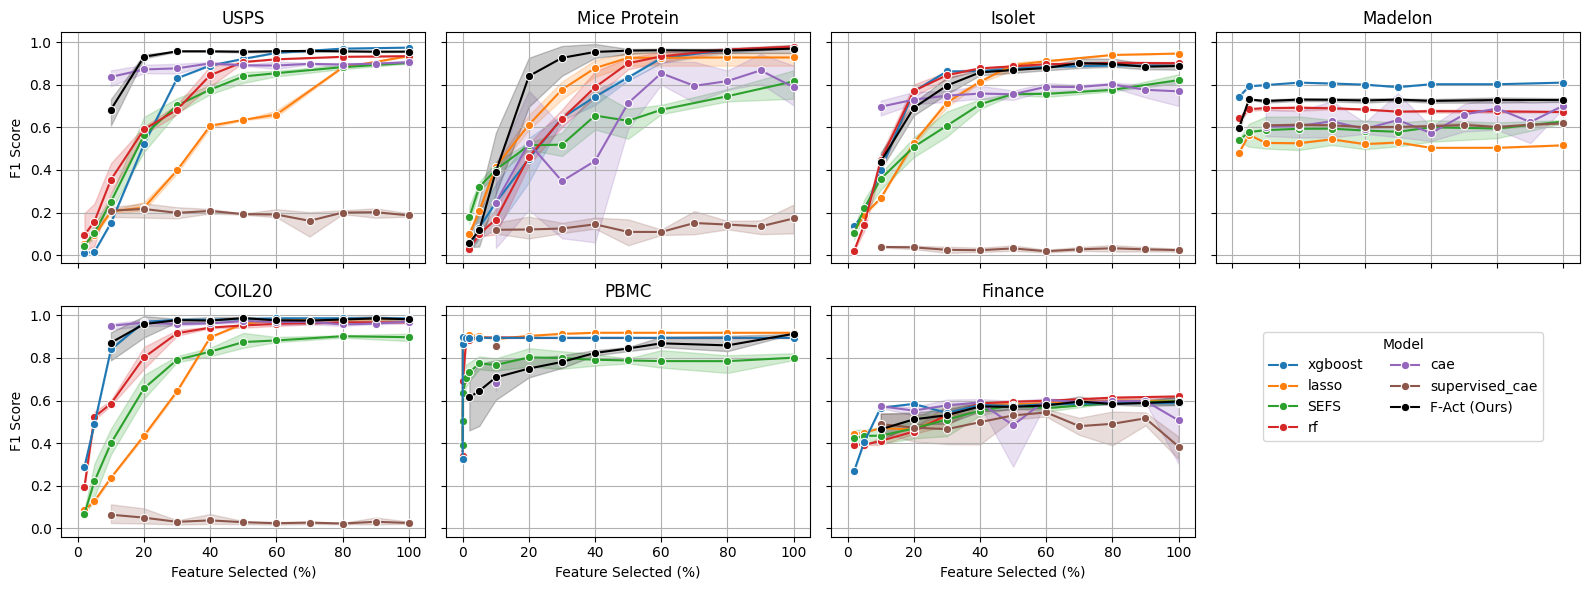

In [13]:
plot_f1_vs_feature_selection_all_datasets(df,save=True)